This notebook loads the remaining datasets and performs data preprocessing, including an outlier check. We’ll apply robust scaling, a technique that makes features less sensitive to outliers and effectively handles non-normal distributions. Robust scaling is especially useful when a dataset contains outliers or has skewed or non-normal distributions, as it centers data around the median and scales it based on the interquartile range (IQR).

Since we’ve already cleaned the application data in *notebook 3_x_Cleaning_ApplicationData*, we’ll only retain the 'SK_ID_CURR' and 'TARGET' columns from this data, excluding all other features. These columns will be used to link with other datasets, and we’ll leverage the `featuretools` library to automate feature engineering across the combined data.

In [2]:
import pandas as pd
import numpy as np

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# import the functions from the file
from notebook_setup import RootPath, config
from my_functions import pie_plot

# Automatically Reload Changes if there are frequent changes to my xx.py file
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# Automatically Reload Changes if there are frequent changes to my xx.py file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# import the functions from the file
from my_functions import (
    summarize_dataframe,
    preprocess_data,
    detect_outliers_iqr_all, 
    winsorize_selected_features, 
    apply_robust_scaling 
)

In [5]:
# Load all sampling data and drop "Unnamed" which is the index column
app_sample = pd.read_csv(f'{config.CleanDataPath}app_sample.csv')
app_sample = app_sample.loc[:, ~app_sample.columns.str.contains('^Unnamed')]
app_sample.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,307474,0,Cash loans,F,Y,N,0,67500.0,1030302.0,40860.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,412537,0,Cash loans,F,Y,Y,0,90000.0,253737.0,26775.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
2,149084,0,Cash loans,M,Y,Y,0,270000.0,1006920.0,45499.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
3,364692,0,Cash loans,M,Y,Y,2,202500.0,495351.0,29497.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,155423,0,Cash loans,M,Y,Y,0,162000.0,264159.0,13617.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [6]:
# Load the rest of sampling data 
bureau_sample = pd.read_csv(f'{config.CleanDataPath}bureau_sample.csv')
bureau_sample = bureau_sample.loc[:, ~bureau_sample.columns.str.contains('^Unnamed')]

bureau_balance_sample = pd.read_csv(f'{config.CleanDataPath}bureau_balance_sample.csv')
bureau_balance_sample = bureau_balance_sample.loc[:, ~bureau_balance_sample.columns.str.contains('^Unnamed')]

previous_sample = pd.read_csv( f'{config.CleanDataPath}previous_sample.csv')
previous_sample = previous_sample.loc[:, ~previous_sample.columns.str.contains('^Unnamed')]

cash_sample = pd.read_csv(f'{config.CleanDataPath}cash_sample.csv')
cash_sample = cash_sample.loc[:, ~cash_sample.columns.str.contains('^Unnamed')]

instalments_sample = pd.read_csv(f'{config.CleanDataPath}instalments_sample.csv')
instalments_sample = instalments_sample.loc[:, ~instalments_sample.columns.str.contains('^Unnamed')]

credit_sample = pd.read_csv(f'{config.CleanDataPath}credit_sample.csv')
credit_sample = credit_sample.loc[:, ~credit_sample.columns.str.contains('^Unnamed')]


# Application Data
we will only retain the 'SK_ID_CURR' and 'TARGET' columns from this data.


In [8]:
app_df = app_sample[['SK_ID_CURR', 'TARGET']]
app_df.head(5)

,SK_ID_CURR,TARGET
0,307474,0
1,412537,0
2,149084,0
3,364692,0
4,155423,0


# Bureau Data

In [10]:
summarize_dataframe(bureau_sample)


Data Total Number of Each Type:
 float64    8
int64      6
object     3
Name: count, dtype: int64

Float Types Count:
 DAYS_CREDIT_ENDDATE        8061
DAYS_ENDDATE_FACT          2846
AMT_CREDIT_MAX_OVERDUE     8308
AMT_CREDIT_SUM            43725
AMT_CREDIT_SUM_DEBT       33434
AMT_CREDIT_SUM_LIMIT       5195
AMT_CREDIT_SUM_OVERDUE      258
AMT_ANNUITY                6332
dtype: int64

Integer Types Count:
 SK_ID_CURR             26430
SK_ID_BUREAU          147248
DAYS_CREDIT             2921
CREDIT_DAY_OVERDUE       181
CNT_CREDIT_PROLONG         8
DAYS_CREDIT_UPDATE      2842
dtype: int64

Object Types Count:
 CREDIT_ACTIVE       4
CREDIT_CURRENCY     3
CREDIT_TYPE        12
dtype: int64

Data Dimension: (147248, 17)


Here, we’ll use the `preprocess_data` function to call two functions: `detect_outliers_iqr_all` and `apply_robust_scaling`. This process will first check for outliers and then apply robust scaling to features with detected outliers.

Outliers detected in 'SK_ID_CURR': 0 rows.
Lower bound: -346026.0, Upper bound: 901640.0

Outliers detected in 'SK_ID_BUREAU': 0 rows.
Lower bound: 2553423.75, Upper bound: 9228709.5

Outliers detected in 'DAYS_CREDIT': 0 rows.
Lower bound: -5278.0, Upper bound: 3136.0

Outliers detected in 'CREDIT_DAY_OVERDUE': 394 rows.
Lower bound: 0.0, Upper bound: 0.0

Outliers detected in 'DAYS_CREDIT_ENDDATE': 5636 rows.
Lower bound: -5998.0, Upper bound: 5321.0

Outliers detected in 'DAYS_ENDDATE_FACT': 0 rows.
Lower bound: -4736.0, Upper bound: 2803.0

Outliers detected in 'AMT_CREDIT_MAX_OVERDUE': 10664 rows.
Lower bound: 0.0, Upper bound: 0.0

Outliers detected in 'CNT_CREDIT_PROLONG': 874 rows.
Lower bound: 0.0, Upper bound: 0.0

Outliers detected in 'AMT_CREDIT_SUM': 10233 rows.
Lower bound: -696380.085, Upper bound: 1048206.78

Outliers detected in 'AMT_CREDIT_SUM_DEBT': 18716 rows.
Lower bound: -120248.54999999999, Upper bound: 160331.4

Outliers detected in 'AMT_CREDIT_SUM_LIMIT': 6705 

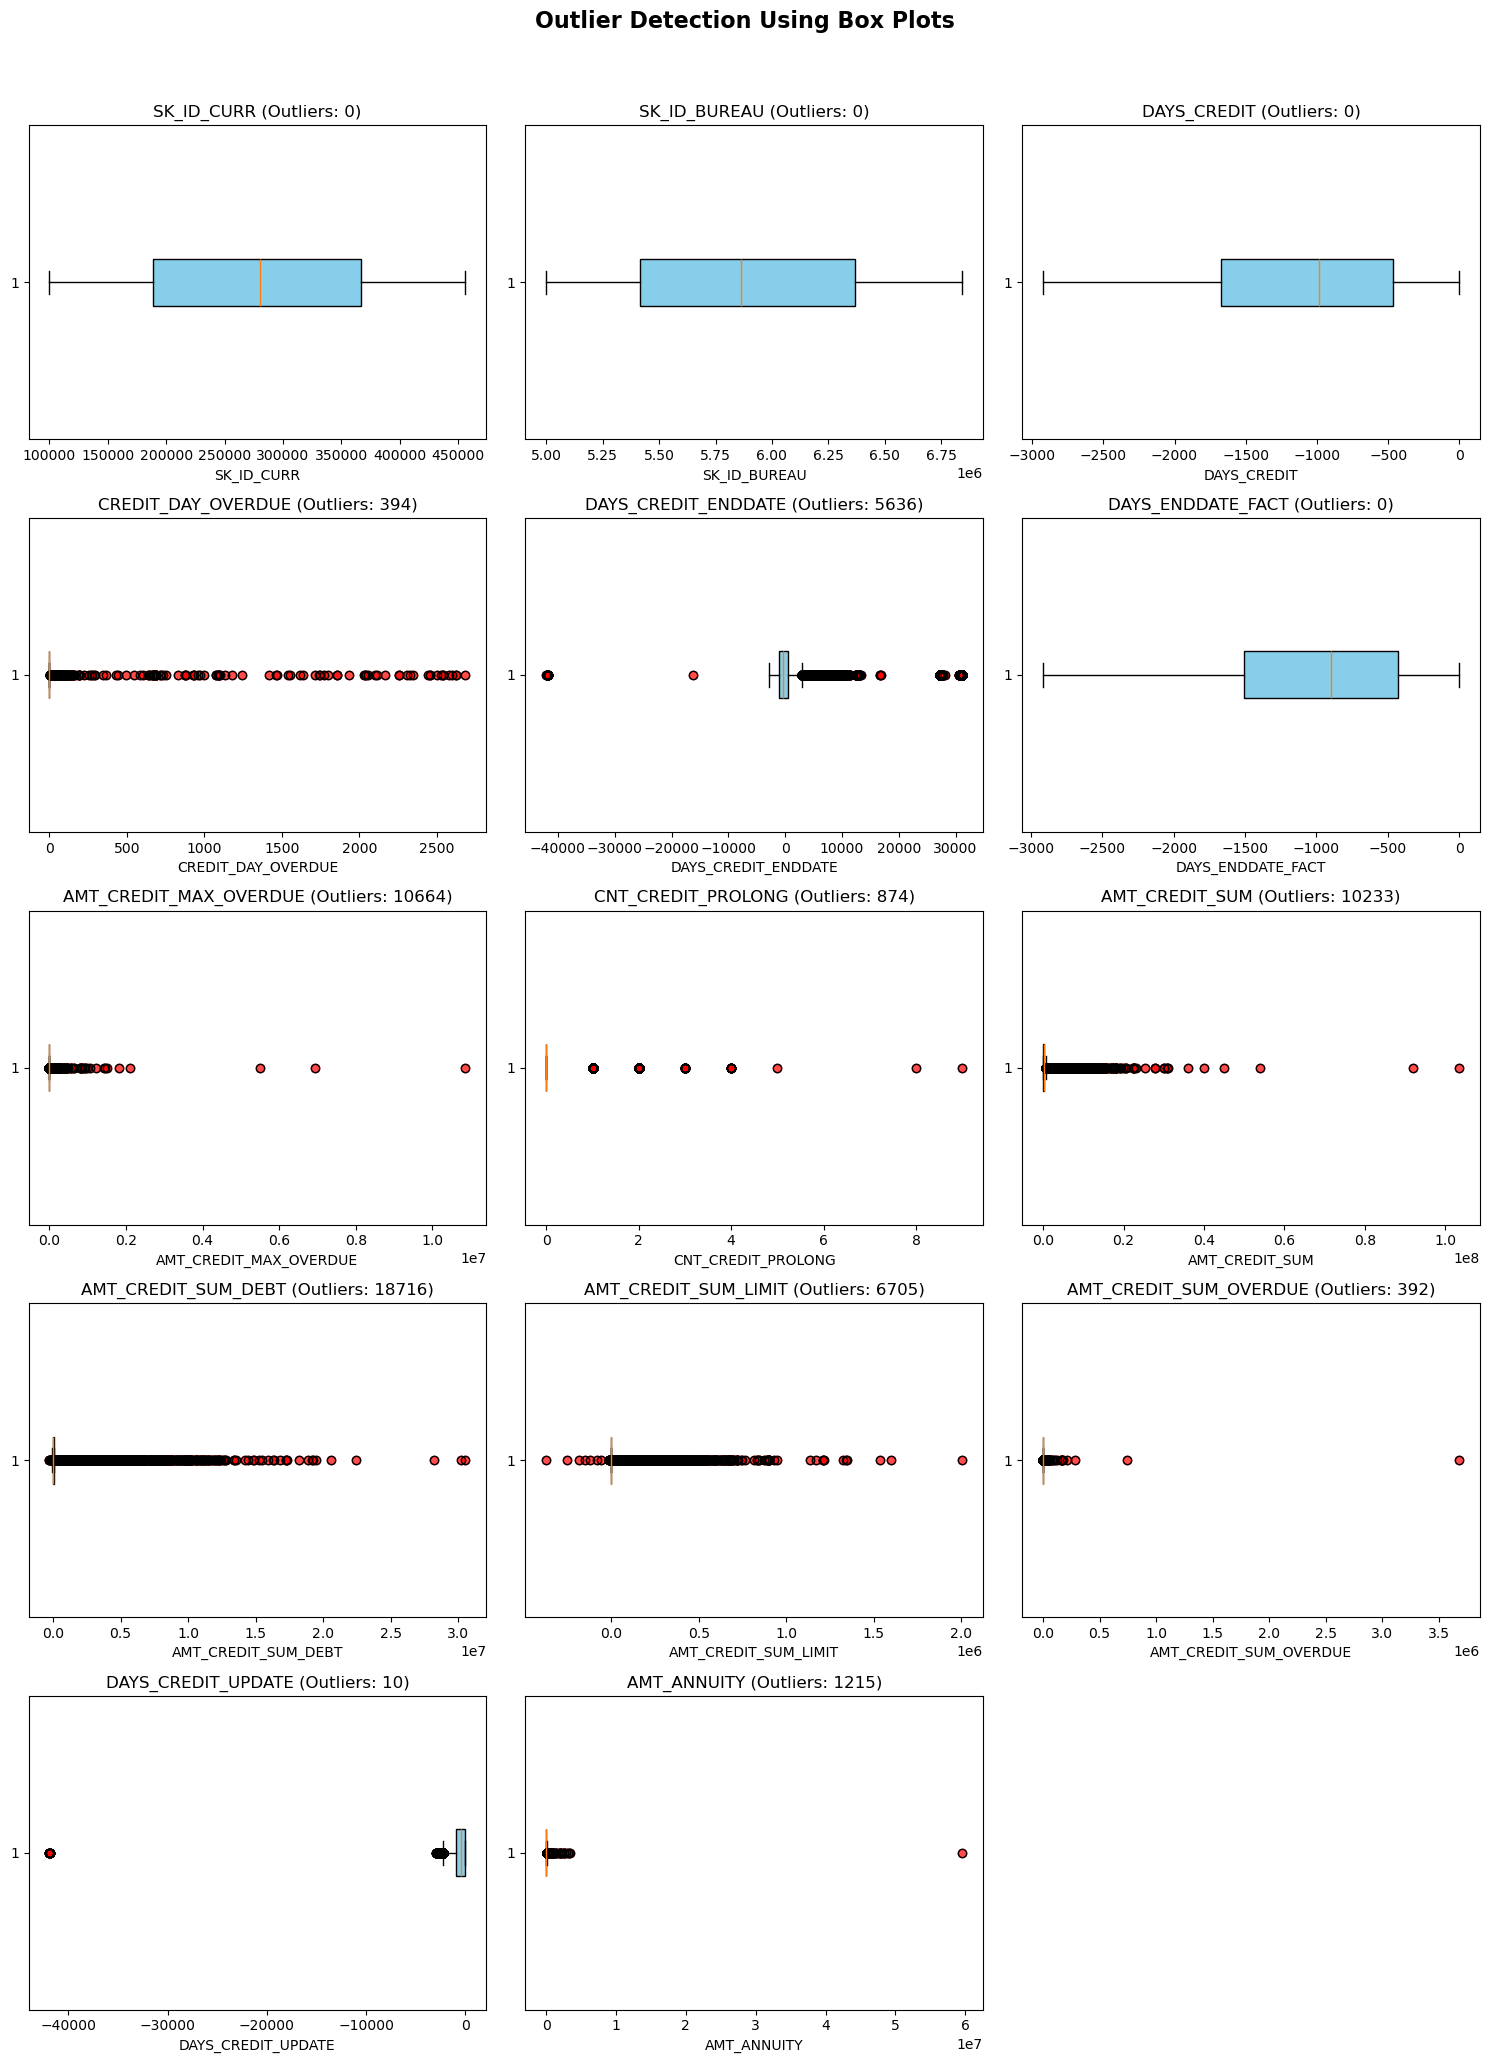

In [12]:
bureau_df = preprocess_data(bureau_sample)

# Bureau Balance Data

Outliers detected in 'SK_ID_BUREAU': 0 rows.
Lower bound: 3069740.5, Upper bound: 8924964.0

Outliers detected in 'MONTHS_BALANCE': 0 rows.
Lower bound: -138.0, Upper bound: 86.0



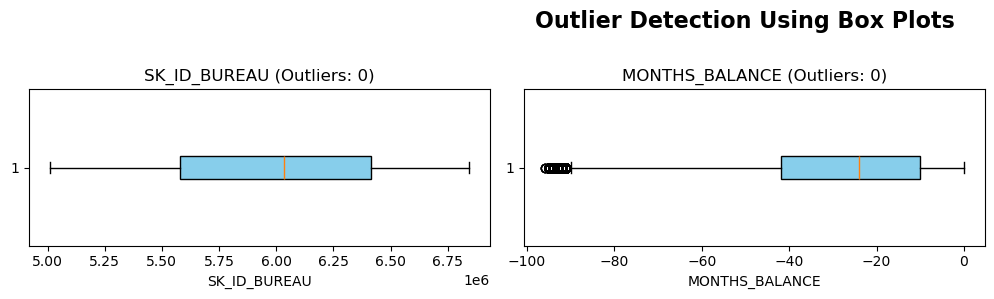

No numeric columns with outliers were found.


In [14]:
bureau_balance_df = preprocess_data(bureau_balance_sample)

# Previous Application Data

Outliers detected in 'SK_ID_PREV': 0 rows.
Lower bound: -1303206.5, Upper bound: 5147160.5

Outliers detected in 'SK_ID_CURR': 0 rows.
Lower bound: -346750.0, Upper bound: 904199.0

Outliers detected in 'AMT_ANNUITY': 1696 rows.
Lower bound: -35881.065, Upper bound: 62536.590000000004

Outliers detected in 'AMT_APPLICATION': 10236 rows.
Lower bound: -461988.09, Upper bound: 661491.0675

Outliers detected in 'AMT_CREDIT': 8330 rows.
Lower bound: -545676.75, Upper bound: 785946.375

Outliers detected in 'AMT_DOWN_PAYMENT': 2486 rows.
Lower bound: -23895.0, Upper bound: 31860.0

Outliers detected in 'AMT_GOODS_PRICE': 7245 rows.
Lower bound: -486054.0, Upper bound: 766165.5

Outliers detected in 'HOUR_APPR_PROCESS_START': 0 rows.
Lower bound: -5.0, Upper bound: 30.0

Outliers detected in 'NFLAG_LAST_APPL_IN_DAY': 499 rows.
Lower bound: 1.0, Upper bound: 1.0

Outliers detected in 'RATE_DOWN_PAYMENT': 1179 rows.
Lower bound: -0.32673637955640117, Upper bound: 0.43564850607520156

Outliers d

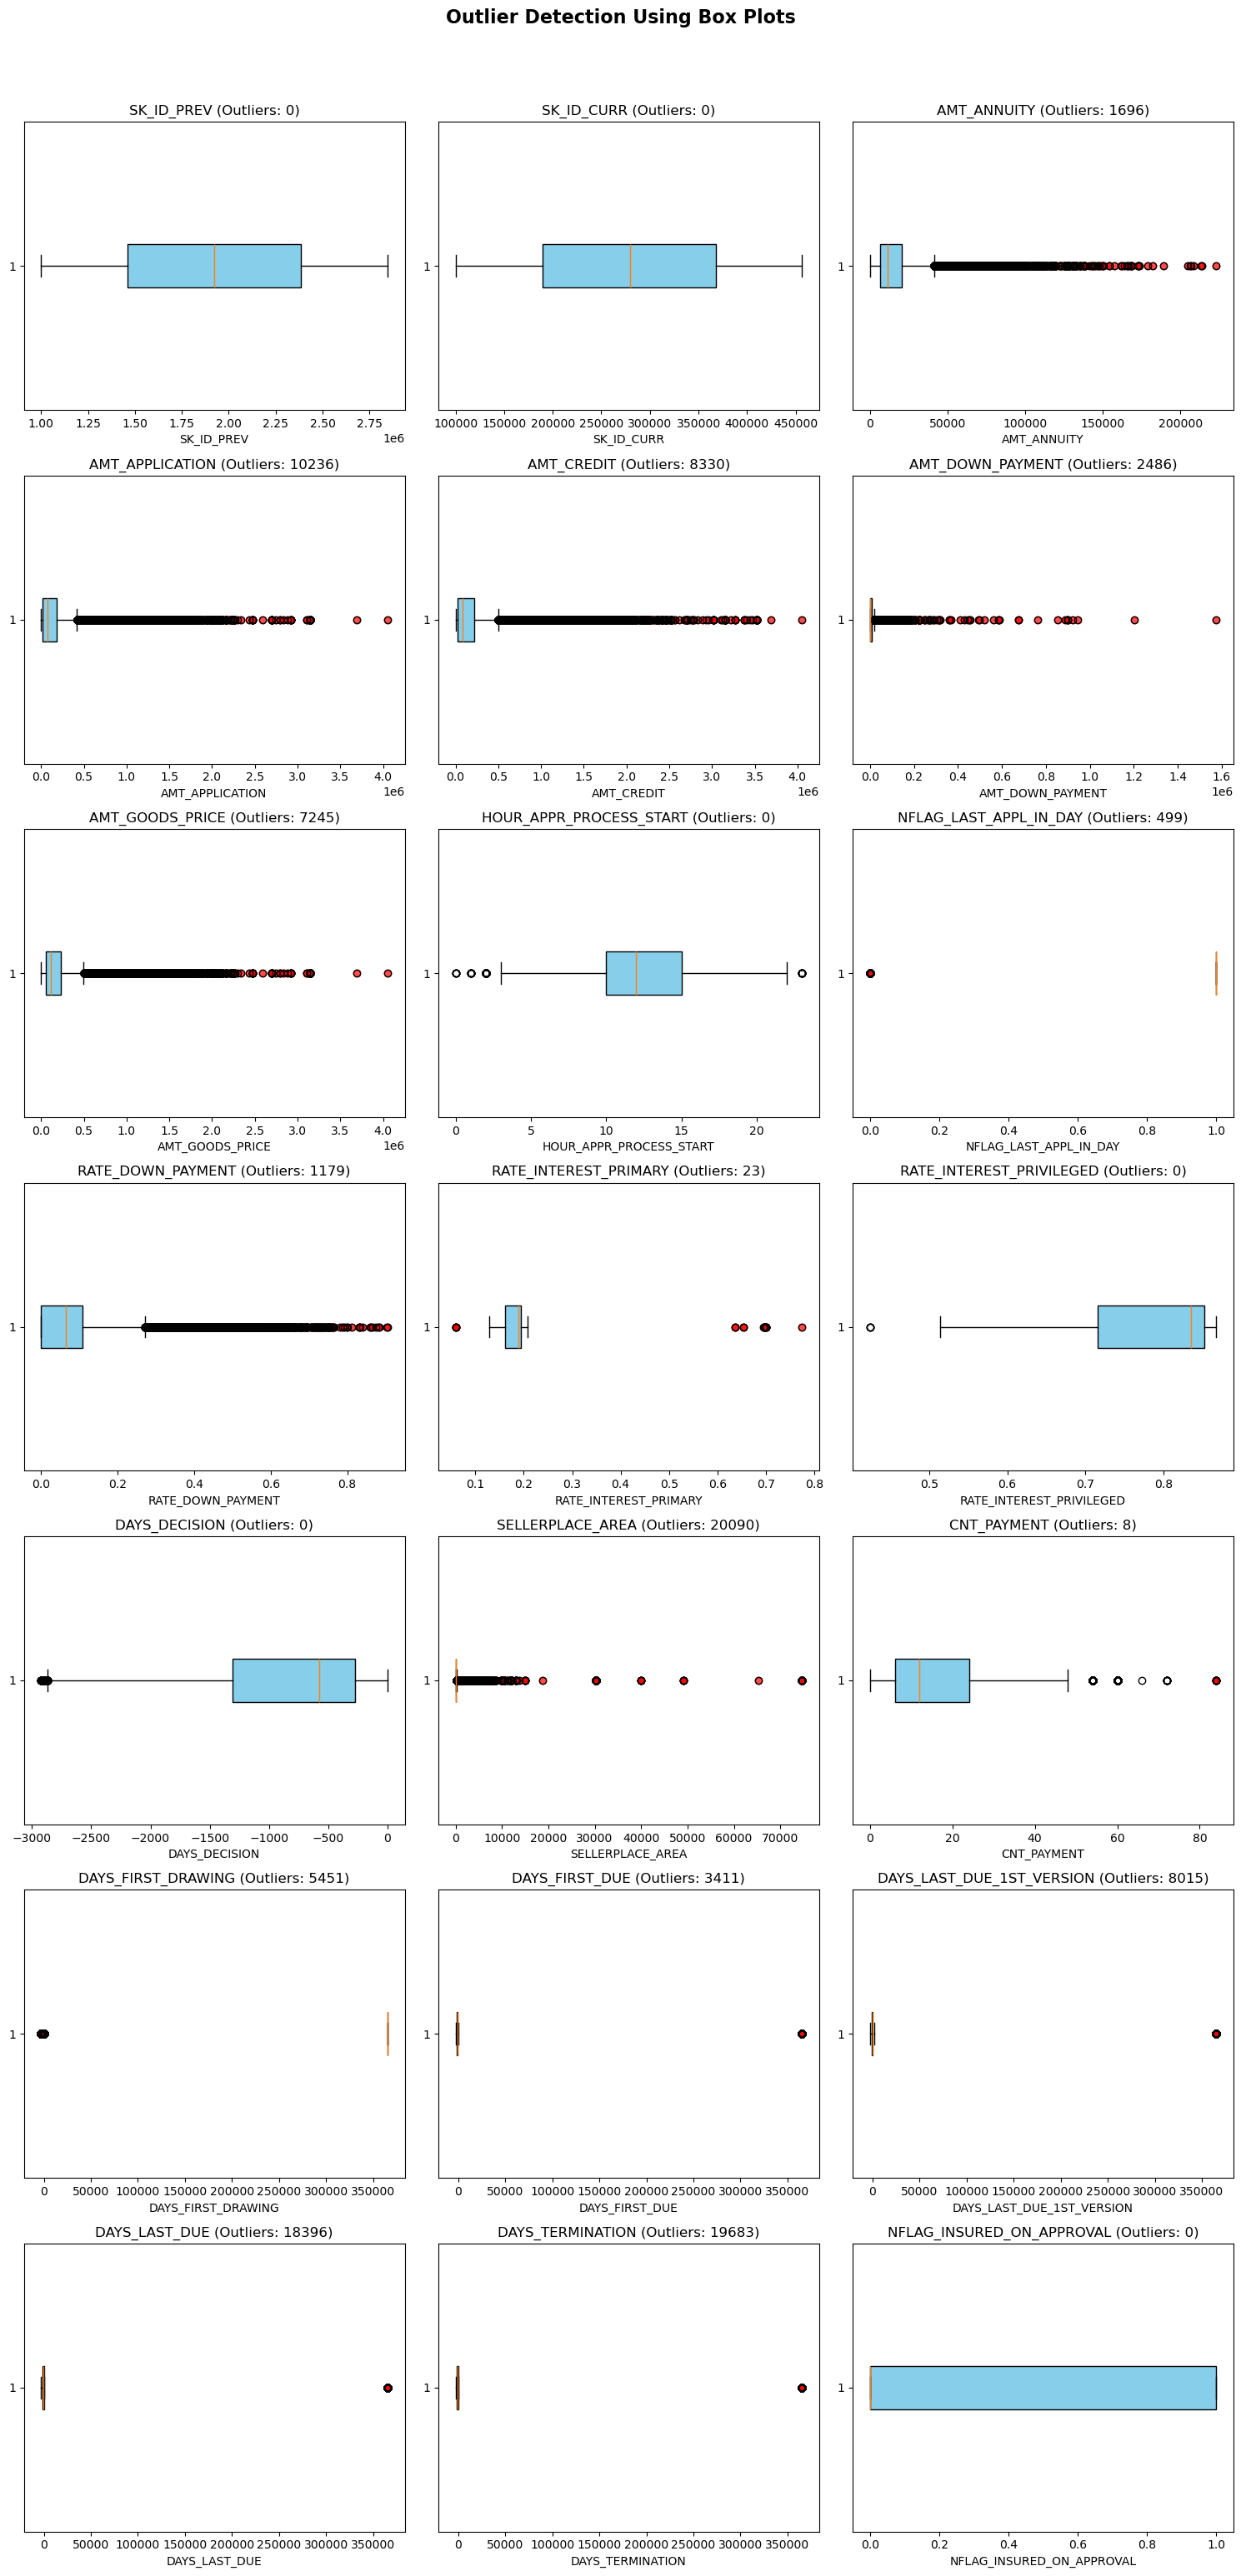

In [16]:
previous_df = preprocess_data(previous_sample)

# Pos Cash Balance Data

Outliers detected in 'SK_ID_PREV': 0 rows.
Lower bound: -1382274.0, Upper bound: 5182067.0

Outliers detected in 'SK_ID_CURR': 0 rows.
Lower bound: -349320.0, Upper bound: 908405.0

Outliers detected in 'MONTHS_BALANCE': 0 rows.
Lower bound: -165.0, Upper bound: 101.0

Outliers detected in 'CNT_INSTALMENT': 143 rows.
Lower bound: -32.0, Upper bound: 66.0

Outliers detected in 'CNT_INSTALMENT_FUTURE': 13635 rows.
Lower bound: -30.0, Upper bound: 47.0

Outliers detected in 'SK_DPD': 19174 rows.
Lower bound: 0.0, Upper bound: 0.0

Outliers detected in 'SK_DPD_DEF': 8969 rows.
Lower bound: 0.0, Upper bound: 0.0



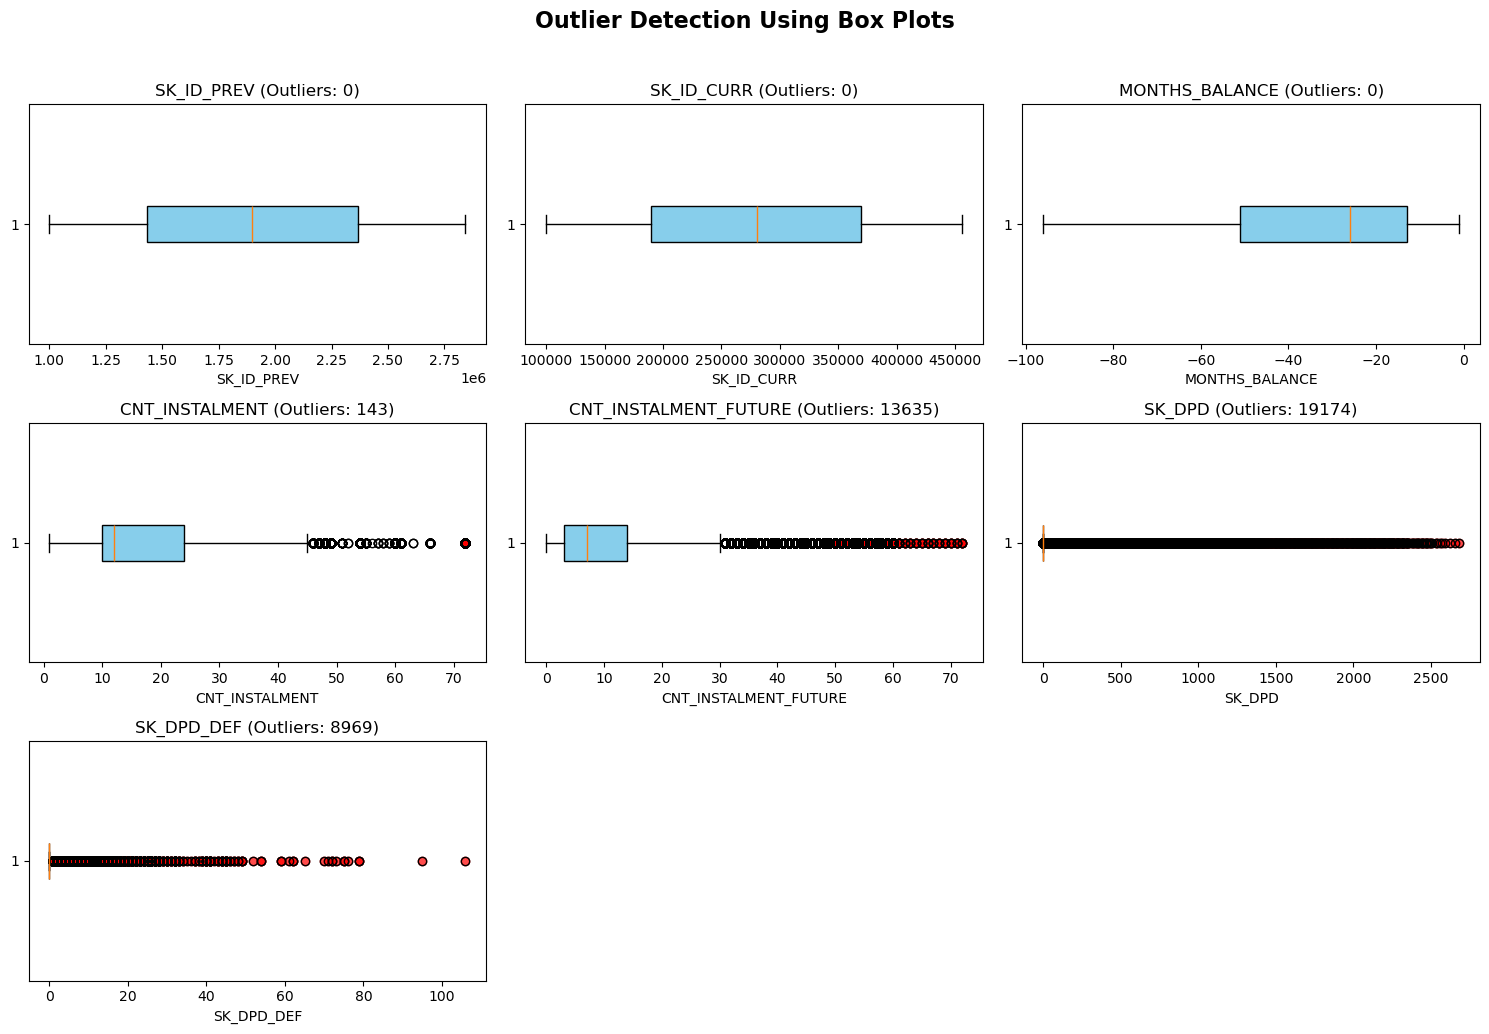

In [18]:
cash_df = preprocess_data(cash_sample )

# Installments payment Data

Outliers detected in 'SK_ID_PREV': 0 rows.
Lower bound: -1369899.0, Upper bound: 5172833.0

Outliers detected in 'SK_ID_CURR': 0 rows.
Lower bound: -348603.0, Upper bound: 908443.0

Outliers detected in 'NUM_INSTALMENT_VERSION': 349973 rows.
Lower bound: 1.0, Upper bound: 1.0

Outliers detected in 'NUM_INSTALMENT_NUMBER': 84307 rows.
Lower bound: -29.0, Upper bound: 48.0

Outliers detected in 'DAYS_INSTALMENT': 0 rows.
Lower bound: -5065.0, Upper bound: 3216.0

Outliers detected in 'DAYS_ENTRY_PAYMENT': 0 rows.
Lower bound: -5071.0, Upper bound: 3203.0

Outliers detected in 'AMT_INSTALMENT': 37302 rows.
Lower bound: -34427.880000000005, Upper bound: 56711.07000000001

Outliers detected in 'AMT_PAYMENT': 41771 rows.
Lower bound: -34640.23499999999, Upper bound: 55693.259999999995



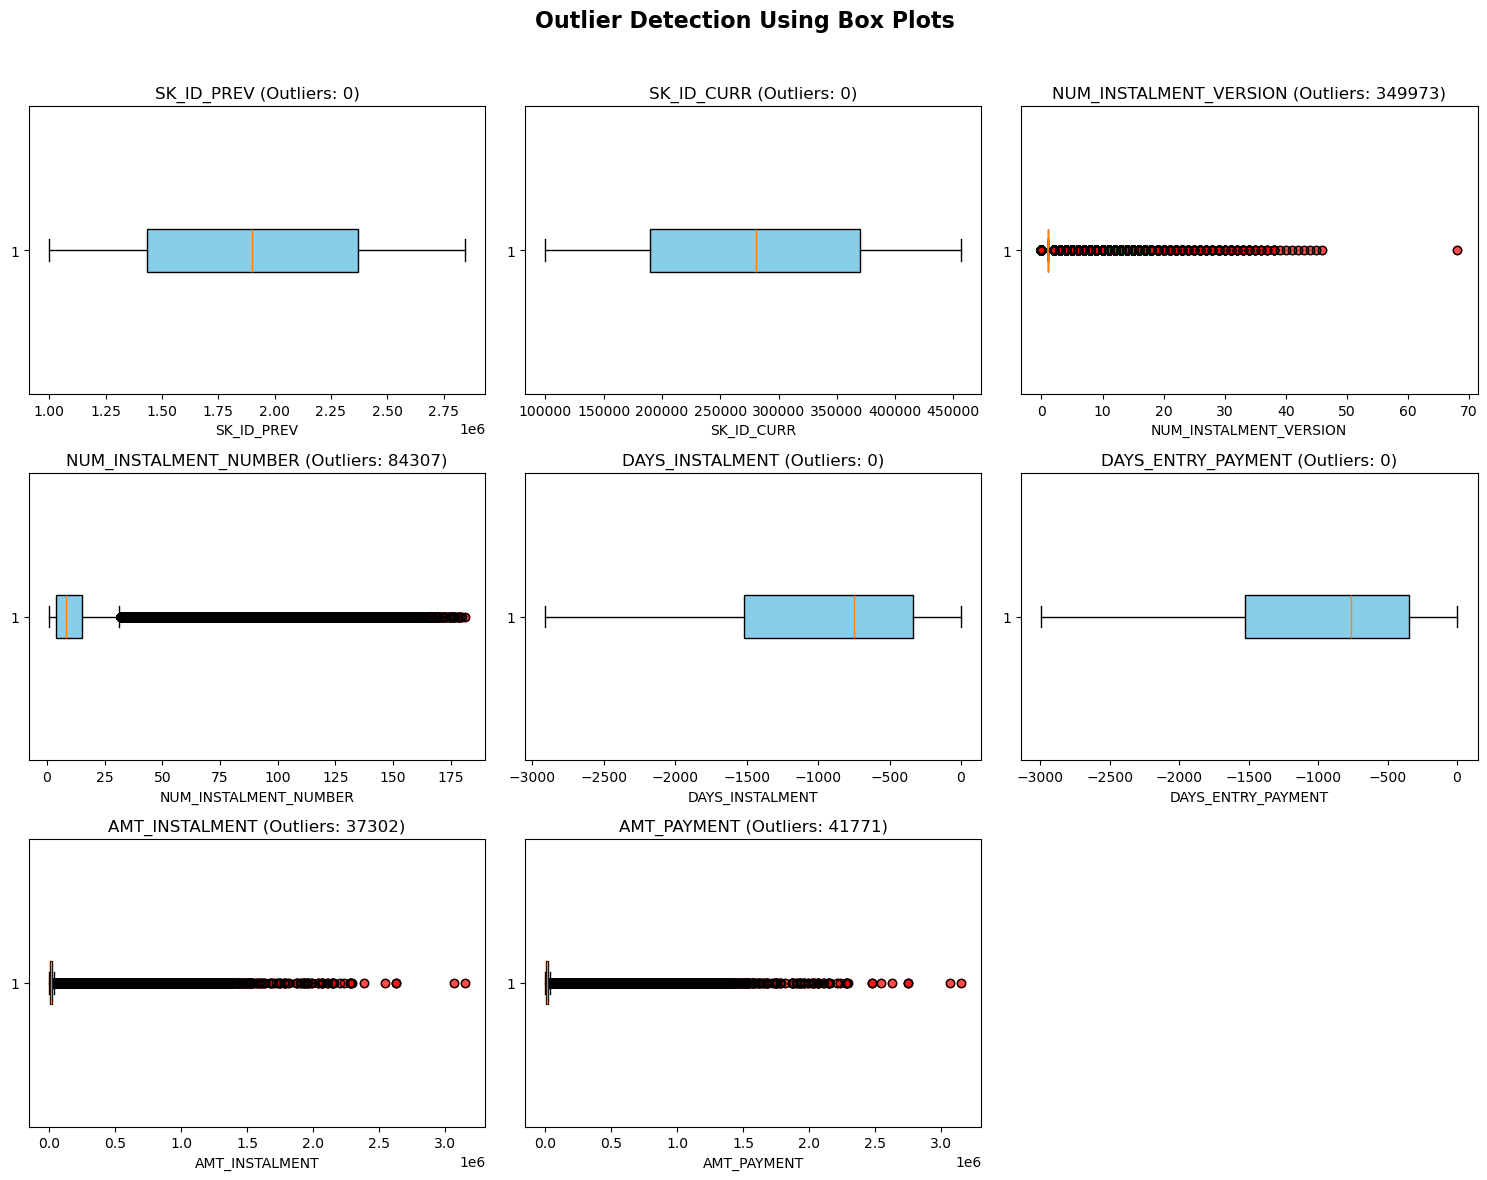

In [20]:
instalments_df = preprocess_data(instalments_sample)

# Credit Balance Data

Outliers detected in 'SK_ID_PREV': 0 rows.
Lower bound: -1369548.0, Upper bound: 5172449.0

Outliers detected in 'SK_ID_CURR': 0 rows.
Lower bound: -348430.0, Upper bound: 907097.0

Outliers detected in 'MONTHS_BALANCE': 0 rows.
Lower bound: -157.0, Upper bound: 102.0

Outliers detected in 'AMT_BALANCE': 7682 rows.
Lower bound: -301450.94999999995, Upper bound: 401934.6

Outliers detected in 'AMT_CREDIT_LIMIT_ACTUAL': 3328 rows.
Lower bound: -495000.0, Upper bound: 765000.0

Outliers detected in 'AMT_DRAWINGS_ATM_CURRENT': 30434 rows.
Lower bound: 0.0, Upper bound: 0.0

Outliers detected in 'AMT_DRAWINGS_CURRENT': 45118 rows.
Lower bound: 0.0, Upper bound: 0.0

Outliers detected in 'AMT_DRAWINGS_OTHER_CURRENT': 742 rows.
Lower bound: 0.0, Upper bound: 0.0

Outliers detected in 'AMT_DRAWINGS_POS_CURRENT': 20985 rows.
Lower bound: 0.0, Upper bound: 0.0

Outliers detected in 'AMT_INST_MIN_REGULARITY': 2053 rows.
Lower bound: -20250.0, Upper bound: 27000.0

Outliers detected in 'AMT_PAYMEN

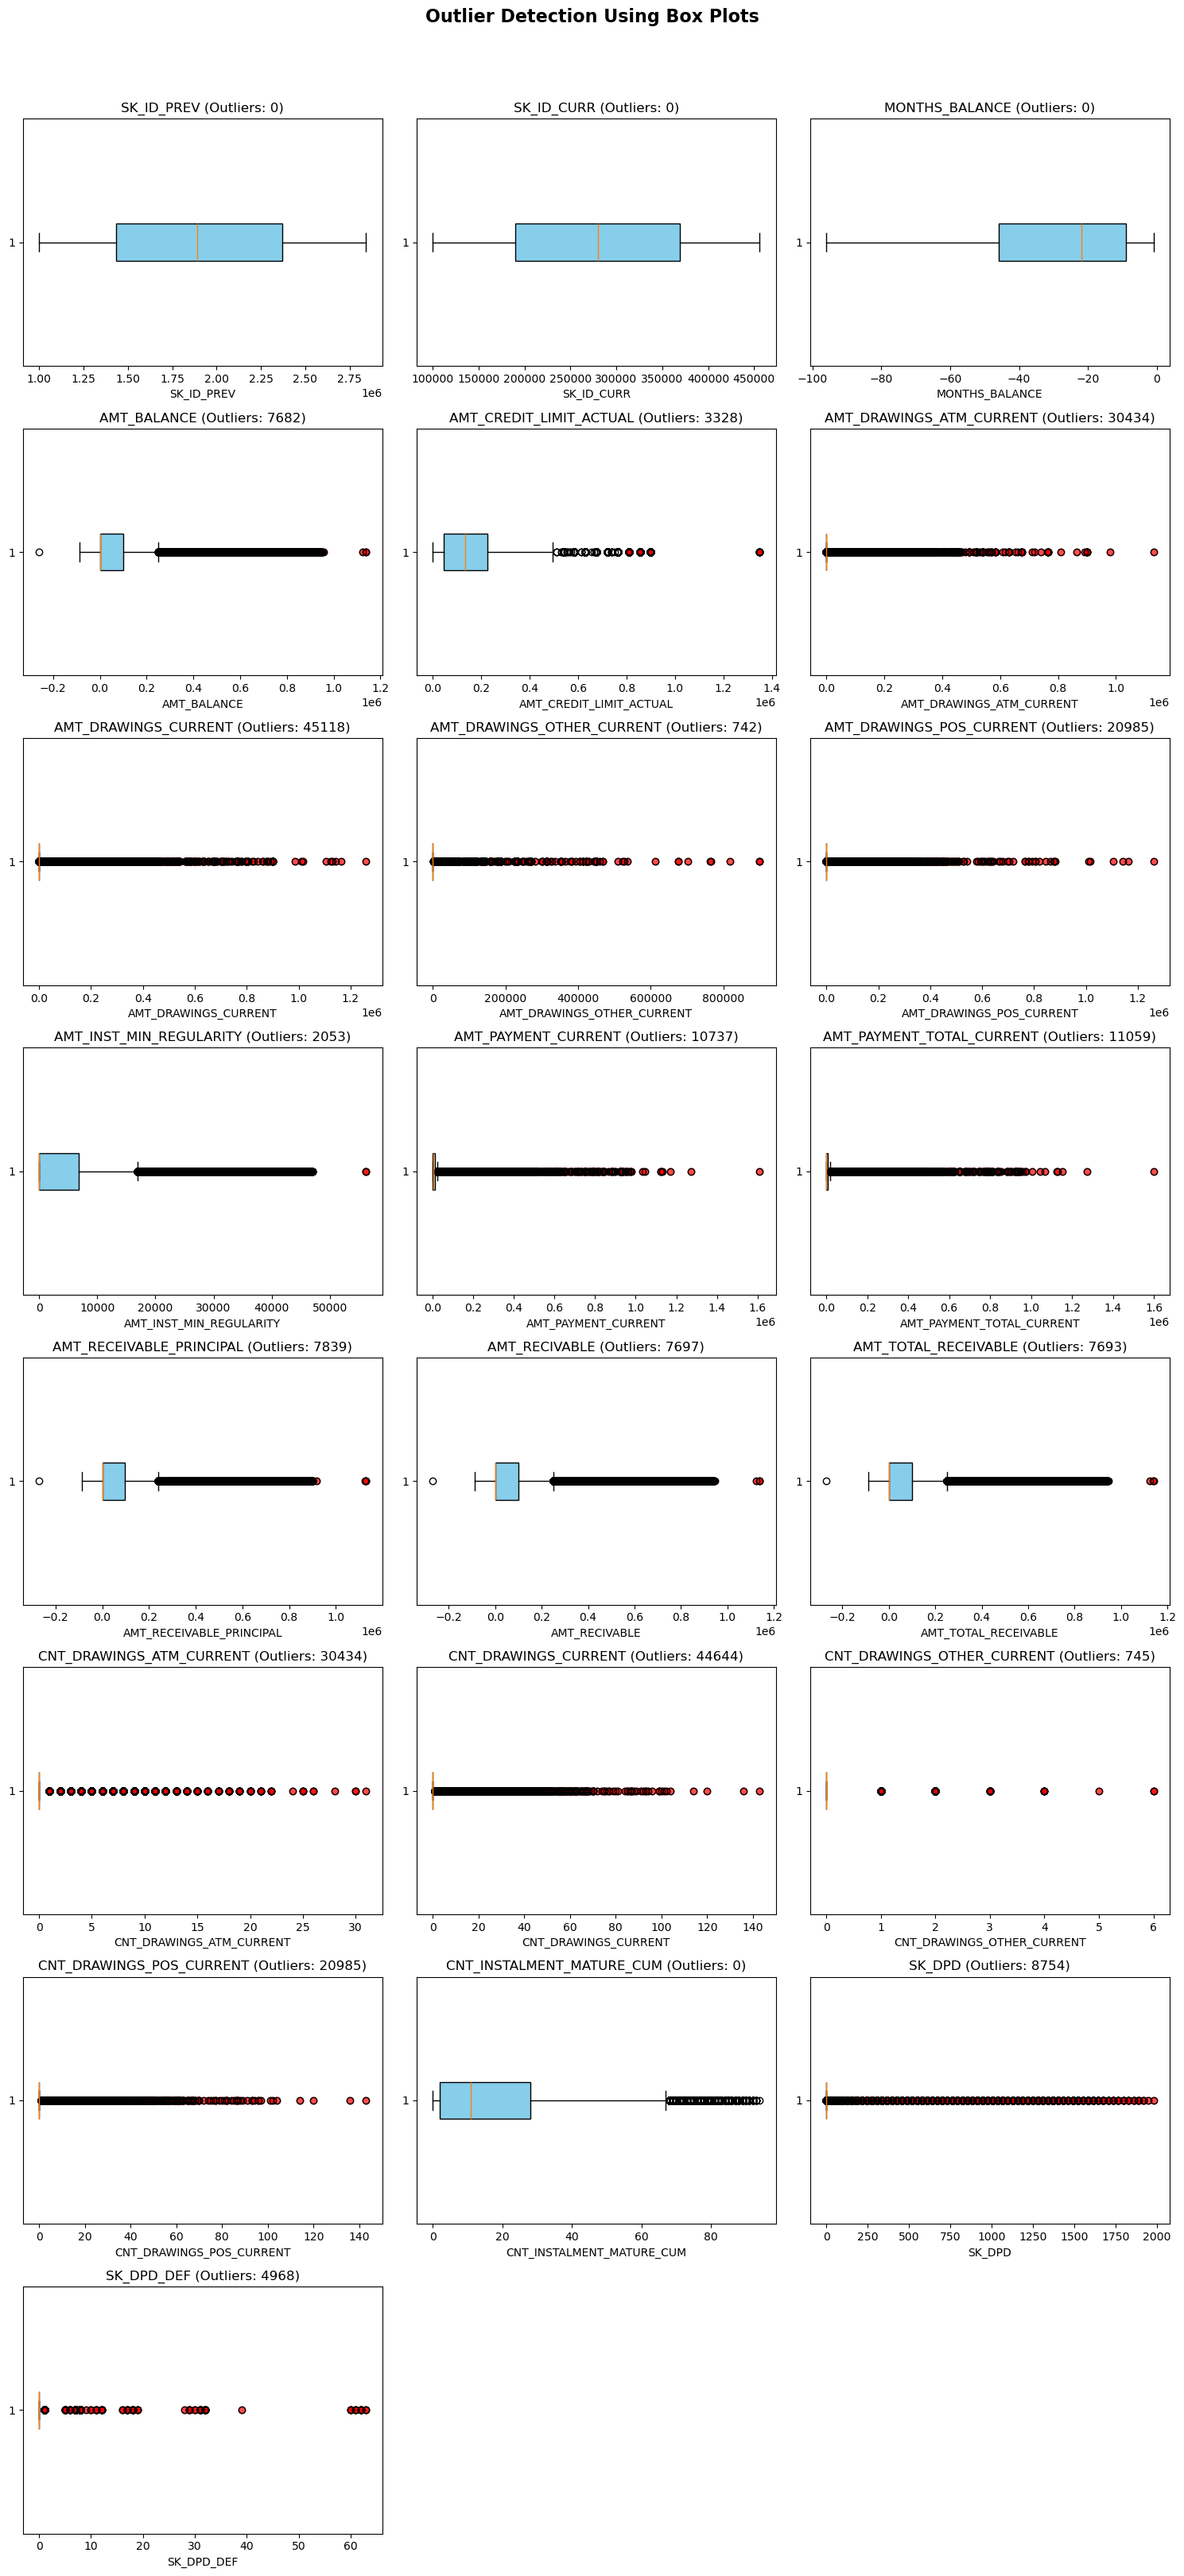

In [22]:
credit_df = preprocess_data(credit_sample)

Save all data to perform dimensionality reduction using FAMD.

In [24]:
app_df.to_csv(f'{config.CleanDataPath}app_df.csv')
bureau_df.to_csv(f'{config.CleanDataPath}bureau_df.csv')
bureau_balance_df.to_csv(f'{config.CleanDataPath}bureau_balance_df.csv')
previous_df.to_csv(f'{config.CleanDataPath}previous_df.csv')
cash_df.to_csv(f'{config.CleanDataPath}cash_df.csv')
instalments_df.to_csv(f'{config.CleanDataPath}instalments_df.csv')
credit_df.to_csv(f'{config.CleanDataPath}credit_df.csv')